# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [3]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [4]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations

asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']

# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [5]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [6]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [7]:
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [8]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [9]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [10]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker

df_std = asl.df.groupby('speaker').std()
df_std

# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [11]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

# Note for later : Would it be better to use grnd-** values instead of raw values ?

# Finish data preparation (left-x-mean has already been added in the asl dataframe)
#asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df['left-x-std']= asl.df['speaker'].map(df_std['left-x'])
asl.df['right-x-mean']= asl.df['speaker'].map(df_means['right-x'])
asl.df['right-x-std']= asl.df['speaker'].map(df_std['right-x'])

asl.df['left-y-mean']= asl.df['speaker'].map(df_means['left-y'])
asl.df['left-y-std']= asl.df['speaker'].map(df_std['left-y'])
asl.df['right-y-mean']= asl.df['speaker'].map(df_means['right-y'])
asl.df['right-y-std']= asl.df['speaker'].map(df_std['right-y'])

# Compute normalized Cartesian coordinates 
asl.df['norm-rx'] = (asl.df['right-x'] - asl.df['right-x-mean']) / asl.df['right-x-std']
asl.df['norm-ry'] = (asl.df['right-y'] - asl.df['right-y-mean']) / asl.df['right-y-std']
asl.df['norm-lx'] = (asl.df['left-x'] - asl.df['left-x-mean']) / asl.df['left-x-std']
asl.df['norm-ly'] = (asl.df['left-y'] - asl.df['left-y-mean']) / asl.df['left-y-std']

# Define a helper name to facilitate their access in the panda dataframe
features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']

#asl.df.head()
asl.df[features_norm].head()


norm-rx   norm-ry   norm-lx   norm-ly
video frame                                        
98    0      1.153232  1.663433 -0.891199  0.741835
      1      1.153232  1.663433 -0.891199  0.741835
      2      1.153232  1.663433 -0.891199  0.741835
      3      1.153232  1.663433 -0.891199  0.741835
      4      1.153232  1.663433 -0.891199  0.741835

In [12]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle

# Remark : It looks like we here have to use grnd-** values instead of raw values 
# otherwise the unit testing test_features_polar fails

# Compute polar coordinates (Note: *theta=arctan2(y,x) but we switch x and y as per the given instructions)
asl.df['polar-rr'] = np.sqrt(asl.df['grnd-rx']**2 + asl.df['grnd-ry']**2)
asl.df['polar-rtheta'] = np.arctan2(asl.df['grnd-rx'],asl.df['grnd-ry'])

#asl.df['polar-lr'] = np.sqrt(np.power(asl.df['left-x'],2) + np.power(asl.df['left-y'],2)) 
asl.df['polar-lr'] = np.sqrt(asl.df['grnd-lx']**2 + asl.df['grnd-ly']**2)
asl.df['polar-ltheta'] = np.arctan2(asl.df['grnd-lx'],asl.df['grnd-ly'])

# Define a helper name to facilitate their access in the panda dataframe
features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

asl.df[features_polar].head()


polar-rr  polar-rtheta    polar-lr  polar-ltheta
video frame                                                   
98    0      113.35784      0.079478  119.603512     -0.100501
      1      113.35784      0.079478  119.603512     -0.100501
      2      113.35784      0.079478  119.603512     -0.100501
      3      113.35784      0.079478  119.603512     -0.100501
      4      113.35784      0.079478  119.603512     -0.100501

In [13]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

# Note for later : Would it be better to use grnd-** values instead of raw values ?

# Compute delta difference coordinates 
 
p=1  # Diff periods

asl.df['delta-rx'] = asl.df['right-x'].diff(p).fillna(0.0) 
asl.df['delta-ry'] = asl.df['right-y'].diff(p).fillna(0.0) 
asl.df['delta-lx'] = asl.df['left-x'].diff(p).fillna(0.0) 
asl.df['delta-ly'] = asl.df['left-y'].diff(p).fillna(0.0) 

# Define a helper name to facilitate their access in the panda dataframe
features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

asl.df[features_delta].head()

delta-rx  delta-ry  delta-lx  delta-ly
video frame                                        
98    0           0.0       0.0       0.0       0.0
      1           0.0       0.0       0.0       0.0
      2           0.0       0.0       0.0       0.0
      3           0.0       0.0       0.0       0.0
      4           0.0       0.0       0.0       0.0

In [14]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like
# TODO define a list named 'features_custom' for building the training set


###### Custom Feature : normalized Cartesian ground coordinates
asl.df['grnd-lx-mean']= asl.df['speaker'].map(df_means['grnd-lx'])
asl.df['grnd-lx-std']= asl.df['speaker'].map(df_std['grnd-lx'])
asl.df['grnd-rx-mean']= asl.df['speaker'].map(df_means['grnd-rx'])
asl.df['grnd-rx-std']= asl.df['speaker'].map(df_std['grnd-rx'])
asl.df['grnd-ly-mean']= asl.df['speaker'].map(df_means['grnd-ly'])
asl.df['grnd-ly-std']= asl.df['speaker'].map(df_std['grnd-ly'])
asl.df['grnd-ry-mean']= asl.df['speaker'].map(df_means['grnd-ry'])
asl.df['grnd-ry-std']= asl.df['speaker'].map(df_std['grnd-ry'])

asl.df['norm-grnd-rx'] = (asl.df['grnd-rx'] - asl.df['grnd-rx-mean']) / asl.df['grnd-rx-std']
asl.df['norm-grnd-ry'] = (asl.df['grnd-ry'] - asl.df['grnd-ry-mean']) / asl.df['grnd-ry-std']
asl.df['norm-grnd-lx'] = (asl.df['grnd-lx'] - asl.df['grnd-lx-mean']) / asl.df['grnd-lx-std']
asl.df['norm-grnd-ly'] = (asl.df['grnd-ly'] - asl.df['grnd-ly-mean']) / asl.df['grnd-ly-std']

# Define a helper name to facilitate their access in the panda dataframe
features_norm_grnd = ['norm-grnd-rx', 'norm-grnd-ry', 'norm-grnd-lx','norm-grnd-ly']


###### Custom Feature : Feature Scaling on ground coordinates
df_mins = asl.df.groupby('speaker').min()
df_maxs = asl.df.groupby('speaker').max()

asl.df['left-grnd-x-min']= asl.df['speaker'].map(df_mins['grnd-lx'])
asl.df['left-grnd-x-max']= asl.df['speaker'].map(df_maxs['grnd-lx'])
asl.df['left-grnd-y-min']= asl.df['speaker'].map(df_mins['grnd-ly'])
asl.df['left-grnd-y-max']= asl.df['speaker'].map(df_maxs['grnd-ly'])
asl.df['right-grnd-x-min']= asl.df['speaker'].map(df_mins['grnd-rx'])
asl.df['right-grnd-x-max']= asl.df['speaker'].map(df_maxs['grnd-rx'])
asl.df['right-grnd-y-min']= asl.df['speaker'].map(df_mins['grnd-ry'])
asl.df['right-grnd-y-max']= asl.df['speaker'].map(df_maxs['grnd-ry'])

asl.df['scale-grnd-rx'] = (asl.df['grnd-rx'] - asl.df['right-grnd-x-min']) / (asl.df['right-grnd-x-max'] - asl.df['right-grnd-x-min'] )
asl.df['scale-grnd-ry'] = (asl.df['grnd-ry'] - asl.df['right-grnd-y-min']) / (asl.df['right-grnd-y-max'] - asl.df['right-grnd-y-min'] )
asl.df['scale-grnd-lx'] = (asl.df['grnd-lx'] - asl.df['left-grnd-x-min']) / (asl.df['left-grnd-x-max'] - asl.df['left-grnd-x-min'] )
asl.df['scale-grnd-ly'] = (asl.df['grnd-ly'] - asl.df['left-grnd-y-min']) / (asl.df['left-grnd-y-max'] - asl.df['left-grnd-y-min'] )

# Define a helper name to facilitate the access in the panda dataframe
features_scale_grnd = ['scale-grnd-rx', 'scale-grnd-ry', 'scale-grnd-lx','scale-grnd-ry']


###### Custom Feature : normalized Polar ground coordinates

# Update means and std to incldue customs features previously added
df_means = asl.df.groupby('speaker').mean()
df_std = asl.df.groupby('speaker').std()

asl.df['polar-rr-mean']= asl.df['speaker'].map(df_means['polar-rr'])
asl.df['polar-rtheta-mean']= asl.df['speaker'].map(df_means['polar-rtheta'])
asl.df['polar-lr-mean']= asl.df['speaker'].map(df_means['polar-lr'])
asl.df['polar-ltheta-mean']= asl.df['speaker'].map(df_means['polar-ltheta'])

asl.df['polar-rr-std']= asl.df['speaker'].map(df_std['polar-rr'])
asl.df['polar-rtheta-std']= asl.df['speaker'].map(df_std['polar-rtheta'])
asl.df['polar-lr-std']= asl.df['speaker'].map(df_std['polar-lr'])
asl.df['polar-ltheta-std']= asl.df['speaker'].map(df_std['polar-ltheta'])

asl.df['norm-polar-rr'] = (asl.df['polar-rr'] - asl.df['polar-rr-mean']) / asl.df['polar-rr-std']
asl.df['norm-polar-rtheta'] = (asl.df['polar-rtheta'] - asl.df['polar-rtheta-mean']) / asl.df['polar-rtheta-std']
asl.df['norm-polar-lr'] = (asl.df['polar-lr'] - asl.df['polar-lr-mean']) / asl.df['polar-lr-std']
asl.df['norm-polar-ltheta'] = (asl.df['polar-ltheta'] - asl.df['polar-ltheta-mean']) / asl.df['polar-ltheta-std']

# Define a helper name to facilitate the access in the panda dataframe
features_polar_norm = ['norm-polar-rr', 'norm-polar-rtheta', 'norm-polar-lr', 'norm-polar-ltheta']


##### Custom Feature : normalized ground r/l x/y coordinates ratio
asl.df['norm-grnd-ratio-r']=asl.df['grnd-rx']/(asl.df['grnd-ry']+0.1)
asl.df['norm-grnd-ratio-l']=asl.df['grnd-lx']/(asl.df['grnd-ly']+0.1)

features_ratio = ['norm-grnd-ratio-r', 'norm-grnd-ratio-l']

##### Custom Feature : Polynomial
asl.df['polynom-r']=asl.df['grnd-rx'] **2 + 2*asl.df['grnd-rx']*asl.df['grnd-ry'] + asl.df['grnd-ry']**2
asl.df['polynom-l']=asl.df['grnd-lx'] **2 + 2*asl.df['grnd-lx']*asl.df['grnd-ly'] + asl.df['grnd-ly']**2

# Update min and max to include customs features previously added
df_mins = asl.df.groupby('speaker').min()
df_maxs = asl.df.groupby('speaker').max()

asl.df['polynom-r-min']= asl.df['speaker'].map(df_mins['polynom-r'])
asl.df['polynom-l-min']= asl.df['speaker'].map(df_mins['polynom-l'])
asl.df['polynom-r-max']= asl.df['speaker'].map(df_maxs['polynom-r'])
asl.df['polynom-l-max']= asl.df['speaker'].map(df_maxs['polynom-l'])

asl.df['norm-polynom-r'] = (asl.df['polynom-r'] - asl.df['polynom-r-min']) / (asl.df['polynom-r-max'] - asl.df['polynom-r-min'] )
asl.df['norm-polynom-l'] = (asl.df['polynom-l'] - asl.df['polynom-l-min']) / (asl.df['polynom-l-max'] - asl.df['polynom-l-min'] )

features_polynom = ['norm-polynom-r', 'norm-polynom-l']


# Define helper names to facilitate access in the panda dataframe

features_custom  = features_delta + features_polar_norm + features_polynom
features_custom2 = features_delta + features_polar 
features_custom3 = features_delta + features_norm_grnd + features_ratio 
features_custom4 = features_norm  + features_polar + features_delta
features_custom5 = features_delta + features_norm_grnd + features_scale_grnd + features_polar_norm + features_ratio + features_polynom

asl.df[features_custom].head()

delta-rx  delta-ry  delta-lx  delta-ly  norm-polar-rr  \
video frame                                                          
98    0           0.0       0.0       0.0       0.0       1.573439   
      1           0.0       0.0       0.0       0.0       1.573439   
      2           0.0       0.0       0.0       0.0       1.573439   
      3           0.0       0.0       0.0       0.0       1.573439   
      4           0.0       0.0       0.0       0.0       1.573439   

             norm-polar-rtheta  norm-polar-lr  norm-polar-ltheta  \
video frame                                                        
98    0               0.959419       0.542499          -0.735219   
      1               0.959419       0.542499          -0.735219   
      2               0.959419       0.542499          -0.735219   
      3               0.959419       0.542499          -0.735219   
      4               0.959419       0.542499          -0.735219   

             norm-polynom-r  norm-polynom-l  
video frame                                  
98    0            0.698255         0.44119  
      1            0.698255         0.44119  
      2            0.698255         0.44119  
      3            0.698255         0.44119  
      4            0.698255         0.44119

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:**

I came to design several feature_custom datasets by selecting/assembling together different features. One of the first that provided reasonably good results was the "feature_custom" one. (The alternate versions have been designed why training the part 3 of this project)
- "feature_custom" combines features_delta, features_polar_norm and features_polybom data subsets.
- First, I wanted to avoid using too much close correlated data (i.e avoid using cartesian and polar coordinates data at the same time, and instead favor more complex (non linear) transformations
- The choice of features_delta aims to capture somekind of "motion change" in the coordinates between frames
- The choice of features_polar_norm brings 3 properties around the coordinates information :
  - The use of polar coordinates, for which I found the angular/theta info nice to use 
  - These coordinates have been computed based on the ground (cartesian) coordinates : Using ground coordinates (taking into account the nose position of the speaker)  is interesting regarding the corpulence of the speaker and its relative position in the video frames
  - The normalization, is always a good practice to improve the efficinecy of the training (it helps to adjusts the values of the differents samples of data to a common scale)
- Finally features_polynom was an attempt at introducing a basic non linear transformation, which seems ok to use at first sight


<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [15]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.020s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [16]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.1138127433205


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [17]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]

hidden state #1
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]

hidden state #2
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [18]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [   0.58333333   87.91666667   12.75        108.5       ]
variance =  [  39.41055556   18.74388889    9.855       144.4175    ]

hidden state #1
mean =  [ -9.30211403  55.32333876   6.92259936  71.24057775]
variance =  [ 16.16920957  46.50917372   3.81388185  15.79446427]

hidden state #2
mean =  [ -5.40587658  60.1652424    2.32479599  91.3095432 ]
variance =  [   7.95073876   64.13103127   13.68077479  129.5912395 ]

logL = -601.3291470028619


In [19]:
#training.get_word_Xlengths('NEW-YORK')
print("** 2 Hidden States / features_ground**")
my_testword = 'NEW-YORK' 
model, logL = train_a_word(my_testword, 2, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

print("\n** 3 Hidden States / features_ground**")
my_testword = 'NEW-YORK' 
model, logL = train_a_word(my_testword, 3, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

print("\n** 4 Hidden States / features_ground **")
my_testword = 'NEW-YORK' 
model, logL = train_a_word(my_testword, 4, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

print("\n** 3 Hidden States / features_custom **")
my_testword = 'NEW-YORK' 
model, logL = train_a_word(my_testword, 3, features_custom) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

** 2 Hidden States / features_ground**
Number of states trained in model for NEW-YORK is 2
hidden state #0
mean =  [-12.36842097  56.05263158   4.57894752  63.10526314]
variance =  [ 14.54900348  32.68196638  13.08640148  31.98944569]

hidden state #1
mean =  [ -0.66666665  55.41666666  24.75000003  61.41666667]
variance =  [  6.5563891   18.57722264  30.68833374   1.91055569]

logL = -349.92636533096555

** 3 Hidden States / features_ground**
Number of states trained in model for NEW-YORK is 3
hidden state #0
mean =  [ -0.66666667  55.41666667  24.75        61.41666667]
variance =  [  6.55638889  18.57722222  30.68833333   1.91055556]

hidden state #1
mean =  [-13.23083914  53.53838664   3.          59.69230103]
variance =  [  1.87938494e+01   1.84032750e+01   7.69247414e-04   1.13688646e+00]

hidden state #2
mean =  [-10.49997656  61.49978905   7.99976561  70.49950778]
variance =  [  0.25166659  20.25166654  24.33503112  18.92261459]

logL = -246.52378230770412

** 4 Hidden States / 

##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [20]:
%matplotlib inline

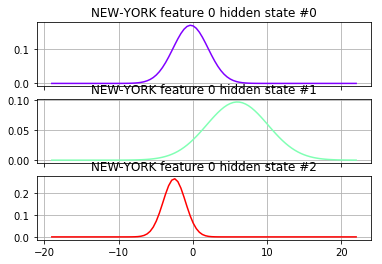

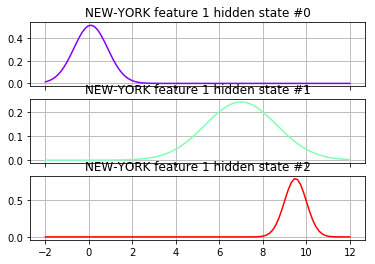

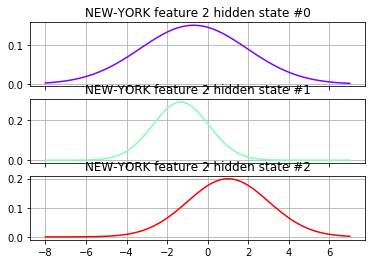

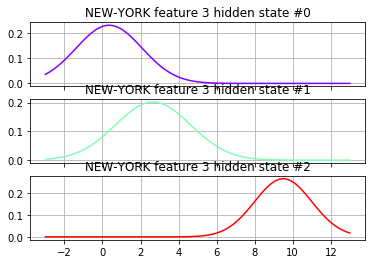

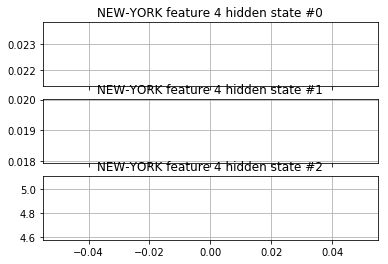

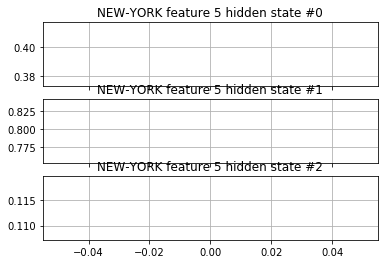

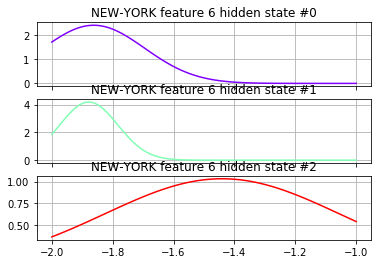

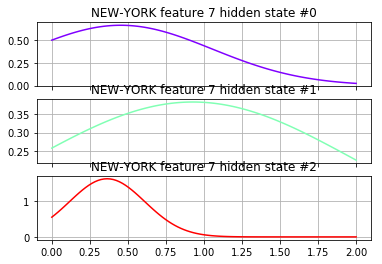

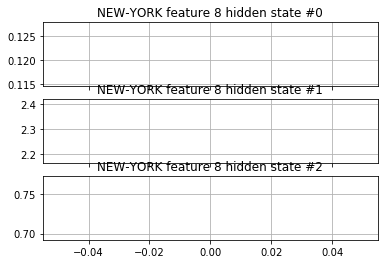

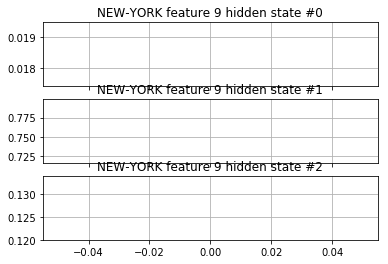

In [21]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [22]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


In [23]:
training = asl.build_training(features_norm)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

training = asl.build_training(features_polar)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

training = asl.build_training(features_delta)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

training = asl.build_training(features_norm_grnd)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))



Number of states trained in model for VEGETABLE is 3
Number of states trained in model for VEGETABLE is 3
Number of states trained in model for VEGETABLE is 3
Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [24]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
#word = 'FISH' # Produce an error (Nb of sequences < default value of K-Fold n_split)
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [25]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [26]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

In [27]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 11 states with time 0.38098903199716005 seconds
Training complete for BOOK with 6 states with time 3.552626880002208 seconds
Training complete for VEGETABLE with 2 states with time 1.449893629993312 seconds
Training complete for FUTURE with 2 states with time 3.4151118690060684 seconds
Training complete for JOHN with 12 states with time 35.972000644003856 seconds


**Note about the previous Training with SelectorCV** :

K-Fold CV requires at least n-splits=2 to be used. By default, in our implementation, K-Fold CV uses n-splits=3, thus it cannot train the word FISH  which is represented in  only 2 sequences in the dataset--> in our implementation, K-Fold CV n-split value is lowered if necessary, provided that it is greater or equal to 2. This allows to be able to perform the training in cases like the FISH word case here

In [28]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
#training = asl.build_training(features_norm)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with time 0.32526042900281027 seconds
Training complete for BOOK with 8 states with time 1.8964980190066854 seconds
Training complete for VEGETABLE with 9 states with time 0.6680010920099448 seconds
Training complete for FUTURE with 9 states with time 2.0975399869930698 seconds
Training complete for JOHN with 13 states with time 20.55076566300704 seconds


In [29]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.8869752600003267 seconds
Training complete for BOOK with 15 states with time 3.8974838919966714 seconds
Training complete for VEGETABLE with 15 states with time 2.478841439995449 seconds
Training complete for FUTURE with 15 states with time 4.012526288002846 seconds
Training complete for JOHN with 15 states with time 22.225972411004477 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**

- SelectorCV : looks rather a good choice. Because of the K-Folds cross-validation process, it is not the fastest one (which is SelectorConstant by the way). By default it is using 3 splits for the K-Folds cross-validation. Using more splits (for example 4), does not seem to bring much improvement with our dataset, while penalizing a lot the execution time. The limited data used here might limits its performance, and the cross-validation process might be a good advantage regarding generalization to new (never seen) data.

- SelectorBIC is interesting :  efficient in performance and time, and especially as it penalize the complexity of the model, thus favoring models with fewer hidden states. That's might be a good point to avoid overfitting

- SelectorDIC seems to favor larger models and seems to be less efficient regarding execution time : maybe not the best approach for our models

- It should be also mentioned that the SelectorConstant, while looking very simple, provide a reasonable performance for a very low execution time.

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [30]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 45.324s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [31]:
from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [32]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [33]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [34]:
# TODO Choose a feature set and model selector
#features = features_ground # change as needed
#model_selector = SelectorConstant # change as needed

features = features_custom4
model_selector = SelectorBIC

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.48314606741573035
Total correct: 92 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
    7: JOHN *PEOPLE *MARY CAN                                        JOHN CAN GO CAN
   12: JOHN CAN *GO1 CAN                                             JOHN CAN GO CAN
   21: JOHN *JOHN *JOHN *JOHN *CAR *CAR *FUTURE *MARY                JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE *LOVE *LIKE IX                                      JOHN LIKE IX IX IX
   28: JOHN LIKE IX *LIKE IX                                         JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY IX IX                                         JOHN LIKE IX IX IX
   36: MARY *JOHN *GIRL *MARY *MARY *JOHN                            MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *MARY *CORN MARY *MARY                                   JOHN IX THINK MARY LOVE
   43: JOHN *JOHN BUY HOUSE        

In [35]:
# TODO Choose a 2nd feature set and model selector
# TODO Recognize the test set and display the result with the show_errors method

features = features_custom2
model_selector = SelectorCV

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5056179775280899
Total correct: 88 out of 178
Video  Recognized                                                    Correct
    2: JOHN *BOOK *ARRIVE                                            JOHN WRITE HOMEWORK
    7: JOHN *DECIDE *HAVE *ARRIVE                                    JOHN CAN GO CAN
   12: JOHN CAN *GO1 CAN                                             JOHN CAN GO CAN
   21: JOHN *VIDEOTAPE WONT *JOHN *CAR *CAR *FUTURE *MARY            JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *MARY *MARY *TELL *MARY                                  JOHN LIKE IX IX IX
   28: JOHN *TELL *MARY *JOHN *MARY                                  JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: MARY *JOHN *IX *GIVE *MARY *MARY                              MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *BILL *CORN MARY *MARY                                   JOHN IX THINK MARY LOVE
   43: JOHN *SHOULD BUY HOUSE       

In [36]:
# TODO Choose a 3rd feature set and model selector
# TODO Recognize the test set and display the result with the show_errors method

features = features_custom4
model_selector = SelectorDIC

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5280898876404494
Total correct: 84 out of 178
Video  Recognized                                                    Correct
    2: JOHN *ARRIVE *ARRIVE                                          JOHN WRITE HOMEWORK
    7: JOHN CAN *IX CAN                                              JOHN CAN GO CAN
   12: JOHN CAN *JOHN CAN                                            JOHN CAN GO CAN
   21: JOHN *JOHN *JOHN *JOHN *CAR *CAR *FUTURE *MARY                JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *JOHN IX IX IX                                           JOHN LIKE IX IX IX
   28: JOHN *MARY IX *JOHN IX                                        JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY IX IX                                         JOHN LIKE IX IX IX
   36: MARY *JOHN *CORN *GIVE *MARY *JOHN                            MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN IX *CORN MARY *MARY                                      JOHN IX THINK MARY LOVE
   43: JOHN *JOHN BUY HOUSE         

In [37]:
### My add-on : Grid-search to evaluate the best ModelSelector / Datasets features

from asl_data import SinglesData, WordsData

features_list = [ features_ground, features_norm, features_polar, features_delta, features_custom, features_custom2, features_custom3, features_custom4, features_custom5 ]
selector_list = [SelectorConstant, SelectorCV, SelectorBIC, SelectorDIC]

# Light version of show_errors function provided in asl_utils.py
def show_errors_light(guesses: list, test_set: SinglesData):
    """ Print WER and sentence differences in tabular form

    :param guesses: list of test item answers, ordered
    :param test_set: SinglesData object
    :return:
        nothing returned, prints error report

    WER = (S+I+D)/N  but we have no insertions or deletions for isolated words so WER = S/N
    """
    S = 0
    N = len(test_set.wordlist)
    num_test_words = len(test_set.wordlist)
    if len(guesses) != num_test_words:
        print("Size of guesses must equal number of test words ({})!".format(num_test_words))
    for word_id in range(num_test_words):
        if guesses[word_id] != test_set.wordlist[word_id]:
            S += 1
    print("\n**** WER = {}".format(float(S) / float(N)))
    print("Total correct: {} out of {}".format(N - S, N))


# Iterate on the a feature list and model selector list
for features in features_list:
    for model_selector in selector_list:  

        start = timeit.default_timer()        
        print("\n\n Recognizing the test set with :")
        print("   - features : ", features)
        print("   - model selector : ", model_selector )
        # Recognize the test set and display the result with the show_errors method
        models = train_all_words(features, model_selector)
        test_set = asl.build_test(features)
        probabilities, guesses = recognize(models, test_set)
        show_errors_light(guesses, test_set)
        end = timeit.default_timer()-start
        print("Elapsed time= {} seconds".format(end))
        print('=====================================================================================================')





 Recognizing the test set with :
   - features :  ['grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly']
   - model selector :  <class 'my_model_selectors.SelectorConstant'>

**** WER = 0.6741573033707865
Total correct: 58 out of 178
Elapsed time= 18.32924834199366 seconds


 Recognizing the test set with :
   - features :  ['grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly']
   - model selector :  <class 'my_model_selectors.SelectorCV'>

**** WER = 0.5280898876404494
Total correct: 84 out of 178
Elapsed time= 109.11736822700186 seconds


 Recognizing the test set with :
   - features :  ['grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly']
   - model selector :  <class 'my_model_selectors.SelectorBIC'>

**** WER = 0.550561797752809
Total correct: 80 out of 178
Elapsed time= 73.96376742399298 seconds


 Recognizing the test set with :
   - features :  ['grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly']
   - model selector :  <class 'my_model_selectors.SelectorDIC'>

**** WER = 0.5786516853932584
Total correct: 75 out

/Users/fdasilva/anaconda/envs/Udacity-AIND17/lib/python3.6/site-packages/hmmlearn/hmm.py:256: RuntimeWarning: invalid value encountered in true_divide
  / (means_weight + denom))
/Users/fdasilva/anaconda/envs/Udacity-AIND17/lib/python3.6/site-packages/hmmlearn/hmm.py:256: RuntimeWarning: invalid value encountered in true_divide
  / (means_weight + denom))



**** WER = 0.5
Total correct: 89 out of 178
Elapsed time= 104.67212856200058 seconds


 Recognizing the test set with :
   - features :  ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly', 'norm-grnd-rx', 'norm-grnd-ry', 'norm-grnd-lx', 'norm-grnd-ly', 'norm-grnd-ratio-r', 'norm-grnd-ratio-l']
   - model selector :  <class 'my_model_selectors.SelectorDIC'>


/Users/fdasilva/anaconda/envs/Udacity-AIND17/lib/python3.6/site-packages/hmmlearn/hmm.py:256: RuntimeWarning: invalid value encountered in true_divide
  / (means_weight + denom))
/Users/fdasilva/anaconda/envs/Udacity-AIND17/lib/python3.6/site-packages/hmmlearn/hmm.py:256: RuntimeWarning: invalid value encountered in true_divide
  / (means_weight + denom))



**** WER = 0.6741573033707865
Total correct: 58 out of 178
Elapsed time= 193.2176800899906 seconds


 Recognizing the test set with :
   - features :  ['norm-rx', 'norm-ry', 'norm-lx', 'norm-ly', 'polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta', 'delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']
   - model selector :  <class 'my_model_selectors.SelectorConstant'>

**** WER = 0.5393258426966292
Total correct: 82 out of 178
Elapsed time= 36.04756060200452 seconds


 Recognizing the test set with :
   - features :  ['norm-rx', 'norm-ry', 'norm-lx', 'norm-ly', 'polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta', 'delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']
   - model selector :  <class 'my_model_selectors.SelectorCV'>

**** WER = 0.5112359550561798
Total correct: 87 out of 178
Elapsed time= 116.14822768200247 seconds


 Recognizing the test set with :
   - features :  ['norm-rx', 'norm-ry', 'norm-lx', 'norm-ly', 'polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta', 'delta-rx', 

/Users/fdasilva/anaconda/envs/Udacity-AIND17/lib/python3.6/site-packages/hmmlearn/hmm.py:256: RuntimeWarning: invalid value encountered in true_divide
  / (means_weight + denom))
/Users/fdasilva/anaconda/envs/Udacity-AIND17/lib/python3.6/site-packages/hmmlearn/hmm.py:256: RuntimeWarning: invalid value encountered in true_divide
  / (means_weight + denom))
/Users/fdasilva/anaconda/envs/Udacity-AIND17/lib/python3.6/site-packages/hmmlearn/hmm.py:256: RuntimeWarning: invalid value encountered in true_divide
  / (means_weight + denom))
/Users/fdasilva/anaconda/envs/Udacity-AIND17/lib/python3.6/site-packages/hmmlearn/hmm.py:256: RuntimeWarning: invalid value encountered in true_divide
  / (means_weight + denom))
/Users/fdasilva/anaconda/envs/Udacity-AIND17/lib/python3.6/site-packages/hmmlearn/hmm.py:256: RuntimeWarning: invalid value encountered in true_divide
  / (means_weight + denom))
/Users/fdasilva/anaconda/envs/Udacity-AIND17/lib/python3.6/site-packages/hmmlearn/hmm.py:256: RuntimeWarn


**** WER = 0.5898876404494382
Total correct: 73 out of 178
Elapsed time= 173.32076694298303 seconds


 Recognizing the test set with :
   - features :  ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly', 'norm-grnd-rx', 'norm-grnd-ry', 'norm-grnd-lx', 'norm-grnd-ly', 'scale-grnd-rx', 'scale-grnd-ry', 'scale-grnd-lx', 'scale-grnd-ry', 'norm-polar-rr', 'norm-polar-rtheta', 'norm-polar-lr', 'norm-polar-ltheta', 'norm-grnd-ratio-r', 'norm-grnd-ratio-l', 'norm-polynom-r', 'norm-polynom-l']
   - model selector :  <class 'my_model_selectors.SelectorBIC'>


/Users/fdasilva/anaconda/envs/Udacity-AIND17/lib/python3.6/site-packages/hmmlearn/hmm.py:256: RuntimeWarning: invalid value encountered in true_divide
  / (means_weight + denom))
/Users/fdasilva/anaconda/envs/Udacity-AIND17/lib/python3.6/site-packages/hmmlearn/hmm.py:256: RuntimeWarning: invalid value encountered in true_divide
  / (means_weight + denom))
/Users/fdasilva/anaconda/envs/Udacity-AIND17/lib/python3.6/site-packages/hmmlearn/hmm.py:256: RuntimeWarning: invalid value encountered in true_divide
  / (means_weight + denom))
/Users/fdasilva/anaconda/envs/Udacity-AIND17/lib/python3.6/site-packages/hmmlearn/hmm.py:256: RuntimeWarning: invalid value encountered in true_divide
  / (means_weight + denom))
/Users/fdasilva/anaconda/envs/Udacity-AIND17/lib/python3.6/site-packages/hmmlearn/hmm.py:256: RuntimeWarning: invalid value encountered in true_divide
  / (means_weight + denom))



**** WER = 0.4943820224719101
Total correct: 90 out of 178
Elapsed time= 125.53108877400518 seconds


 Recognizing the test set with :
   - features :  ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly', 'norm-grnd-rx', 'norm-grnd-ry', 'norm-grnd-lx', 'norm-grnd-ly', 'scale-grnd-rx', 'scale-grnd-ry', 'scale-grnd-lx', 'scale-grnd-ry', 'norm-polar-rr', 'norm-polar-rtheta', 'norm-polar-lr', 'norm-polar-ltheta', 'norm-grnd-ratio-r', 'norm-grnd-ratio-l', 'norm-polynom-r', 'norm-polynom-l']
   - model selector :  <class 'my_model_selectors.SelectorDIC'>


/Users/fdasilva/anaconda/envs/Udacity-AIND17/lib/python3.6/site-packages/hmmlearn/hmm.py:256: RuntimeWarning: invalid value encountered in true_divide
  / (means_weight + denom))
/Users/fdasilva/anaconda/envs/Udacity-AIND17/lib/python3.6/site-packages/hmmlearn/hmm.py:256: RuntimeWarning: invalid value encountered in true_divide
  / (means_weight + denom))
/Users/fdasilva/anaconda/envs/Udacity-AIND17/lib/python3.6/site-packages/hmmlearn/hmm.py:256: RuntimeWarning: invalid value encountered in true_divide
  / (means_weight + denom))
/Users/fdasilva/anaconda/envs/Udacity-AIND17/lib/python3.6/site-packages/hmmlearn/hmm.py:256: RuntimeWarning: invalid value encountered in true_divide
  / (means_weight + denom))
/Users/fdasilva/anaconda/envs/Udacity-AIND17/lib/python3.6/site-packages/hmmlearn/hmm.py:256: RuntimeWarning: invalid value encountered in true_divide
  / (means_weight + denom))



**** WER = 0.5955056179775281
Total correct: 72 out of 178
Elapsed time= 222.0746545259899 seconds


**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**

Following the grid search exploration, it looks like the use of **feature_custom4 (features_delta + features_polar + features_norm)** seems to provides some of the best results, whatever the ModelSelector used. As mentioned in question 1, the use of feature delta looks interesting to capture "motion between frames", and the features_polar based on ground_coordinates is helpfull to somehow "normalize" the data between the different speakers/framing. 

Combined with SelectorBIC, we have achieved **WER of 0.483** which is very good for a 0-gram recognizing system as used here. **The fact that BIC is penalizing larger models might explain why this selector has achieved the best results (better generalization)** on the test dataset  

Very close in results, the K-Fold Cross-validation is also (and as expected) very good at generalization. Other Selectors have given very good results too with that dataset and features choice (WER 0.539/ConstantSelector, 0.511/SelectorCV, 0.528/SelectorDIC)

Usually, given all our customs features selections, and the trends noticed in our results, we can conclude that :

- For "reasonably good results" and very low execution time (in the 30 sec range) , we should use SelectorConstant
- For the lowest WER score (best results), we should use SelectorBIC, which took 2-3 much more time to execute than SelectorConstant (in the range of 90 sec)
- SelectorCV results are very close to SelectorBIC results, but require a slightly more execution time (in the range of 110-120 sec). Should the dataset be larger, I suspect SelectorBIC to show a clearer superiority over SelectorCV regarding the execution time. 
- SelectorDIC usually require more than 200 sec for results that are also close to SelectorCV ones. So definitively not a good option in our case, better use SelectorBIC

All in all, SelectorBIC is the "go to" choice for model selection

Because we are using a 0-gram recognizing system, the performance (measured with the WER score) is limited. Using 1-gram (or 2-gram) recognizing system design would certainly improve a lot the results : by taking into account the previous "word(s)", it would then help to refine the probability of the word being guessed (eliminating some of the possible words, based on the probability they occurs after the word(s) previously detected).


<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [38]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 30.617s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [ ]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()